In [39]:
import numpy as np
import music21 as m21
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import json

In this Deep Learning project, I will try to generate simple melodies using neural networks. This project was proposed by Valerio Velardo - The Sound of AI's youtube channel (https://www.youtube.com/c/ValerioVelardoTheSoundofAI), and seemed particularly relevant to me.  
Indeed, in addition to the particular data represented by melodies, it's a project that has enabled me to familiarize myself with time series, which are then integrated into an LSTM network. This assignment emphasizes my ability to work with a type of data I had no prior knowledge of.

The dataset comes from the website KernScores (https://kern.humdrum.org/), and consists of numerous german folk songs, in *.krn* format. (I intended to try with other kinds of music, but the training of the model was too long).

This project requires basic knowledges in music theory. I tried to explain each step thanks to figures and examples.

<h1 style="color:blue; font-weight:bold;"> Visualization of an example </h1>

In [2]:
dataset_path = './deutschl/erk'
dataset_encoded_path = './encoded_songs/'

In [3]:
path_example_file = './deutschl/test/deut5147.krn'

In [4]:
song_example = m21.converter.parse(path_example_file)

Usually, to correctly view the score of a music21 object, we use the directly integrated *show* function, which works with third-party dependencies such as MuseScore or Lily. I explained how to install MuseScore in the README file.  

If you want to avoid any installation, you could still look at my *melody_generation.pdf* file, where the scores are displayed.
If you still want to run the following script, without showing the scores, you can change the value of the parameter *MuseScore_installed* to False.

In [5]:
MuseScore_installed = True

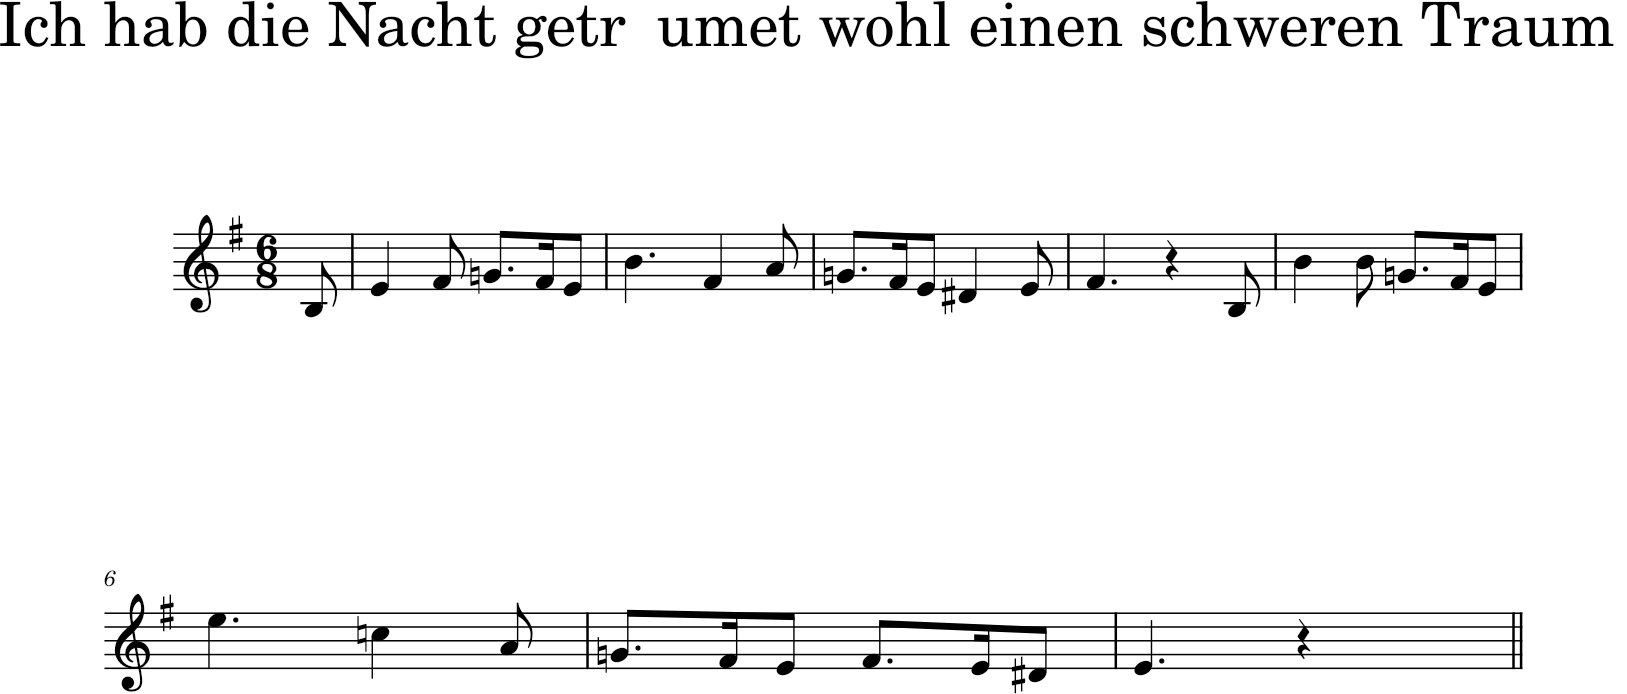

In [6]:
if MuseScore_installed:
    song_example.show()

First and foremost, it is necessary to understand that a single note is defined by two components : its **pitch**, linked to its frequency, and its **duration**.  

The first step of the pre-processing is to remove all melodies of the database containing a note that does not have a tolerated duration, which could pose problems for the future neural network. Here, durations are expressed in quarters notes, so we choose to keep the sixteenths (0.25), the eighths (0.5), the dotted eighths (0.75), the quarters (1), the dotted quarters (1.5), the half notes (2), the dotted half notes (3) and the whole note (4). Below is a plot of the different notes and their corresponding durations. I found this picture on the website www.piano-keyboard-guide.com and added the dotted notes.

(-0.5, 931.5, 301.5, -0.5)

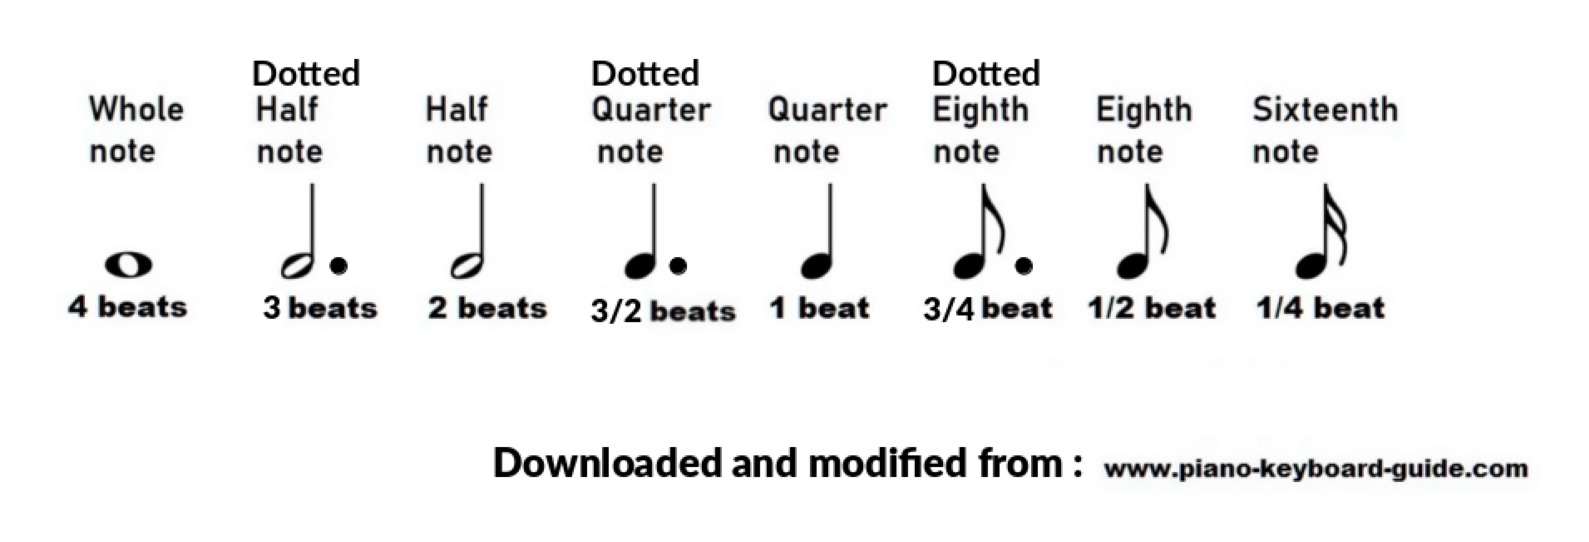

In [7]:
plt.figure(figsize=(10,15))
note_durations_img = cv2.imread('./basic_knwoledges/note_durations.png')
plt.imshow(note_durations_img)
plt.axis('off')

In [8]:
acceptable_durations = [0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]
def filter_acceptable_duration(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    else:
        return True

There are a huge number of keys, so we want to avoid having too many in the learning base. This way, we'll need less data to train our model.  
That's why we transpose all the music to C sharp or A minor.  

Sometimes, the key is directly indicated at the beggining of the partition, but if it is not, we estimate it thanks to the analyze function provided in m21.

In [9]:
def transpose_key(song):
    key = (song.getElementsByClass(m21.stream.Part)[0]).getElementsByClass(m21.stream.Measure)[0][4]
    if not isinstance(key, m21.key.Key):
        key = song.analyze('key')

    if key.mode == 'major':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('C'))
    elif key.mode == 'minor':
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch('A'))

    transposed_song = song.transpose(interval)
    return transposed_song

In [10]:
key_before_transposition = song_example.getElementsByClass(m21.stream.Part)[0].getElementsByClass(m21.stream.Measure)[0][4]
print('The key of the song before its transposition is :',key_before_transposition.tonicPitchNameWithCase, key_before_transposition.mode)

key_after_transposition = transpose_key(song_example).getElementsByClass(m21.stream.Part)[0].getElementsByClass(m21.stream.Measure)[0][4]
print('The key of the song after its transposition is :',key_after_transposition.tonicPitchNameWithCase, key_after_transposition.mode)

The key of the song before its transposition is : e minor
The key of the song after its transposition is : a minor


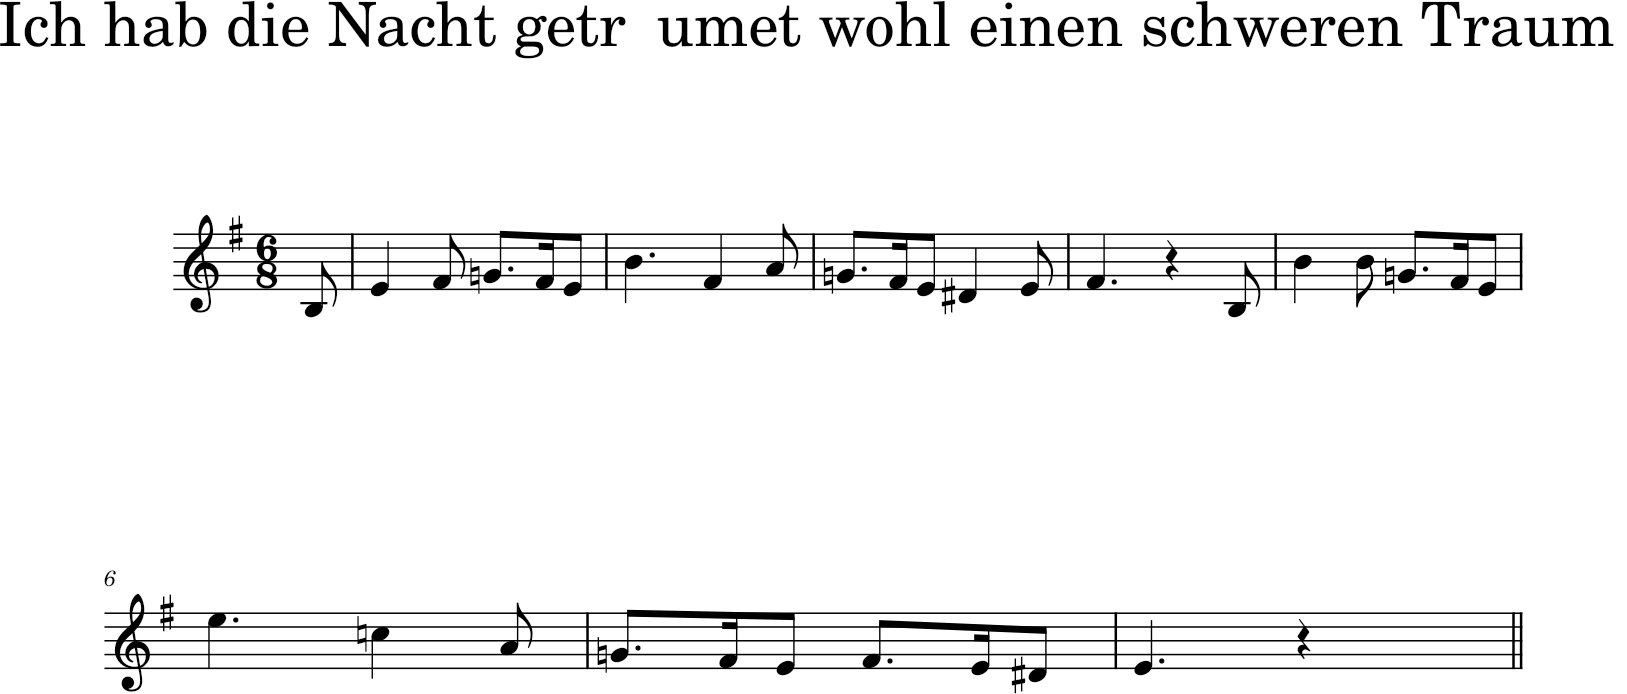

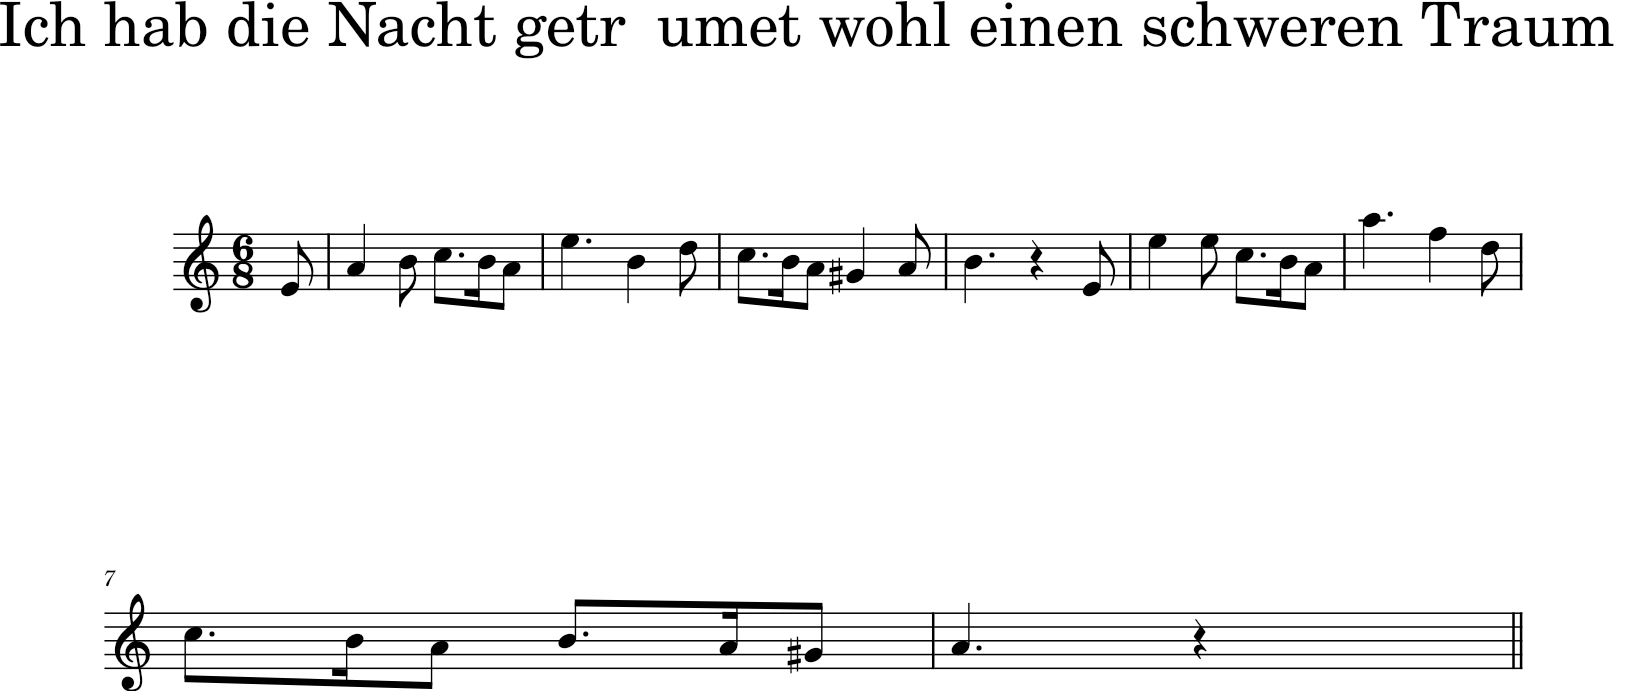

In [11]:
song_example.show()
transpose_key(song_example).show()

The next step of preprocessing is to encode song into string format.  
Each note will be encoded the following way :
- An integer (corresponding to the MIDI encoding, which translates the pitch of a note into an integer). The middle C (C4) is encoded by 60. The complete encodage is shown below (figure extracted from the website https://www.researchgate.net/figure/88-notes-classical-keyboard-Note-names-and-MIDI-numbers_fig8_283460243)
- The duration : each serie encode a quarter, encoded by 4 sixteenth. If a note is held during a whole quarter, we fill the serie with "_".
- A rest is encoded by a "r".

For instance, a quarter C4 is encoded \[60, '\_', '\_', '\_']

(-0.5, 1239.5, 247.5, -0.5)

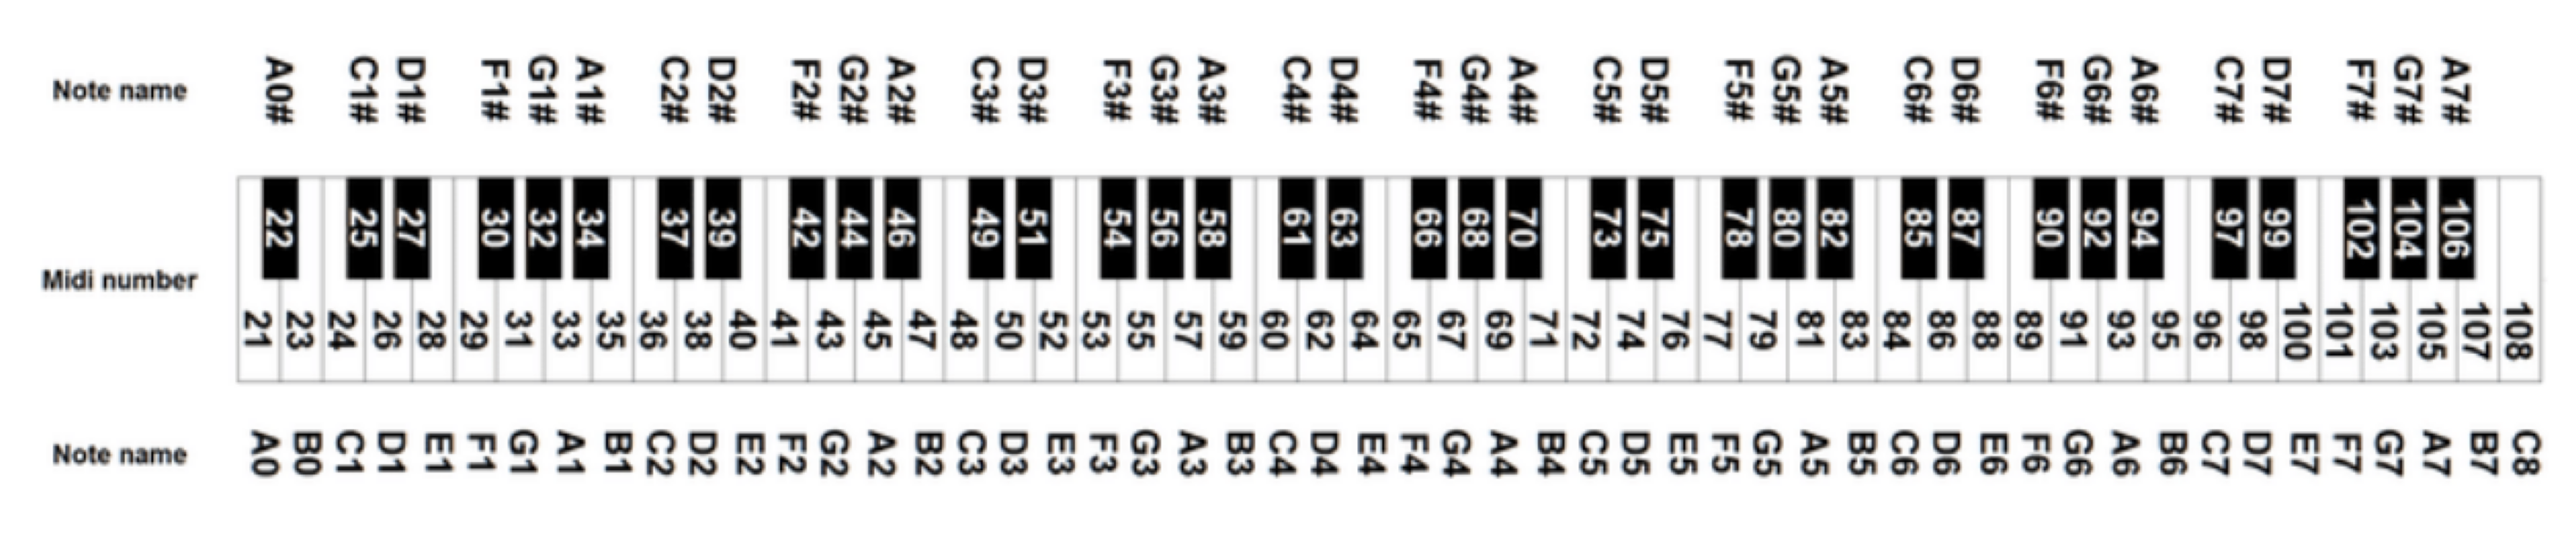

In [12]:
plt.figure(figsize=(18,15))
midi_notation_img = cv2.imread('./basic_knwoledges/midi_notation.png')
plt.imshow(midi_notation_img)
plt.axis('off')

In [13]:
def encode_notes(song):
    encoded_song=[]
    time_step = 0.25
    for entity in song.flatten().notesAndRests:
        if isinstance(entity, m21.note.Note):
            symbol = str(entity.pitch.midi)
        elif isinstance(entity, m21.note.Rest):
            symbol = 'r'
        steps = int(entity.duration.quarterLength / time_step)
        for step in range(steps):
            if step==0:
                encoded_song.append(symbol)
            else:
                encoded_song.append('_')
    encoded_song_txt = ''
    for element in encoded_song:
        encoded_song_txt = encoded_song_txt + element + ' '
    return encoded_song_txt

Once the melodies have been encoded as explained above, we download each sequence as a text file, then concatenate all the sequences into a single file.  
To do this, it is necessary to set a maximum sequence length, and then define a separator between the different encodings.

In [14]:
def save_song_as_txt(encoded_song_txt, file_name, dataset_encoded_path):
    output_dir = dataset_encoded_path
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    file_name_txt = file_name.split('.')[-2]
    with open(output_dir + file_name_txt + '.txt', 'w') as file:
        file.write(encoded_song_txt)

In [15]:
sequence_length = 64
def write_single_files(dataset_path, dataset_encoded_path):
    for path, subdir, files in os.walk(dataset_path):
        for file in files:
            if file.split('.')[-1]=='krn':
                complete_path = os.path.join(path, file)
                subfolder = complete_path.split('/')[-2]
                song = m21.converter.parse(complete_path)
                if filter_acceptable_duration(song, acceptable_durations):
                    transposed_song = transpose_key(song)
                    encoded_song = encode_notes(transposed_song)
                    save_song_as_txt(encoded_song, file, dataset_encoded_path)
                else:
                    pass

write_single_files(dataset_path, dataset_encoded_path)

In [16]:
start_symbol = '/ '* sequence_length
def concatenate_songs(dataset_encoded_path):
    whole_song_sequence = ''
    for file in os.scandir(dataset_encoded_path):
        if file.path.split('.')[-1]=='txt' and file.path.split('/')[-1]!='complete_seq.txt':
            with open(file.path, 'r') as file:
                encoded_song = file.read()
                file.close()
            whole_song_sequence = whole_song_sequence + encoded_song + start_symbol
        with open(dataset_encoded_path + 'complete_seq.txt', 'w') as file:
            file.write(whole_song_sequence[:-1])
    return whole_song_sequence

complete_seq = concatenate_songs(dataset_encoded_path)

Next, we need to map the sequences in such a way as to make them comprehensible to neural networks. At this stage, the sequences contain strings, which need to be translated into ints. 
To do this, we create a dictionary in which we assign an integer for each different character, including rests 'r', note holders '_' and separators '/', which we save in a json file.

In [17]:
def mapping_song(whole_sequence):
    mappings = {}
    vocab = []
    seq_list = whole_sequence.split()
    for element in seq_list:
        if element not in vocab:
            vocab.append(element)
    for i, symbol in enumerate(vocab):
        mappings[symbol]=i
    with open('./encoded_songs/mapping.json', 'w') as file:
        json.dump(mappings, file, indent=4)
    return vocab, mappings

vocab, mapping = mapping_song(complete_seq)

In [18]:
def convert_sequence_to_int_serie(seq_song):
    converted_seq_to_int = []
    with open('./encoded_songs/mapping.json', 'r') as file:
        dict = json.load(file)
    for symbol in seq_song.split():
        converted_seq_to_int.append(dict[symbol])
    return converted_seq_to_int

int_serie = convert_sequence_to_int_serie(complete_seq)

<h1 style="color:blue; font-weight:bold;"> Generation of the model's training set </h1>

Finally, at this stage, we can generate a training set for our future model. Here's an example of how to build a training set:

Consider a sequence ('61', '\_', '\_', '63', '\_', '62', '62', '\_', '\_', '63', ...) encoded with the following integers: (4, 2, 2, 3, 2, 1, 1, 2, 2, 3, ...)
To build the training set, we move a window of size 'sequence_len'. In this example, let's set sequence_len = 3.
The input is the content of the window, whereas the target is the symbol following the window. Then, we move forward the window.
Here is the result on our example :  
- Step 1:  (**[4, 2, 2]**, **3**, 2, 1, 1, 2, 2, 3, ...) # The input **[4, 2, 2]** is the input, **3** is the target
- Step 2:  (4, **[2, 2, 3]**, **2**, 1, 1, 2, 2, 3, ...) # The input **[2, 2, 3]** is the input, **2** is the target
- Step 3:  (4, 2, **[2, 3, 2]**, **1**, 1, 2, 2, 3, ...) # The input **[2, 3, 2]** is the input, **1** is the target
- Start again along the whole sequence ... 

In [19]:
def generate_training_dataset(converted_seq, sequence_len, vocab):
    nb_of_possible_seq = len(converted_seq)-sequence_len 
    input = []
    target = []
    for k in range(nb_of_possible_seq):
        input.append(converted_seq[k:k+sequence_len])
        target.append(converted_seq[k+sequence_len])
    vocab_size = len(vocab)
    input_oh = keras.utils.to_categorical(input, num_classes=vocab_size)
    target = np.array(target)
    return input_oh, target
    

In [20]:
X, y = generate_training_dataset(int_serie, sequence_length, vocab)

In [21]:
print('Input shape : ', X.shape)
print('Target shape : ', y.shape)

Input shape :  (362178, 64, 38)
Target shape :  (362178,)


<h1 style="color:blue; font-weight:bold;"> Model Conception </h1>

Obviously, for this kind of task, we'll be using an RNN. More precisely, to optimize long-term memory management, we'll be using an LSTM network.

The model was trained in Google Colab using a TPU. Unfortunately, I didn't have the opportunity to test several hyperparameter combinations or network architectures due to the very long training time. For this reason, I opted directly for a fairly simple model, using a layer of LSTM, and integrating dropout at several levels to avoid overfitting as much as possible.

At the end of the 40 epochs training (7h), I plotted the training curves in my Colab session, from which I took a screenshot, hence their import.

In [22]:
## Here, I commented this cell in order to avoid to initiate the training while running all cells.

# input = keras.layers.Input(shape=(None, X.shape[2]))
# x = keras.layers.LSTM(units=256, recurrent_dropout=0.2)(input)
# x = keras.layers.Dropout(0.2)(x)
# output = keras.layers.Dense(X.shape[2], activation = 'softmax')(x)
# model = keras.Model(input, output)

# model.compile(optimizer='adam',
#               loss = 'sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# model.fit(X, y, epochs=40, batch_size=32)

(-0.5, 587.5, 451.5, -0.5)

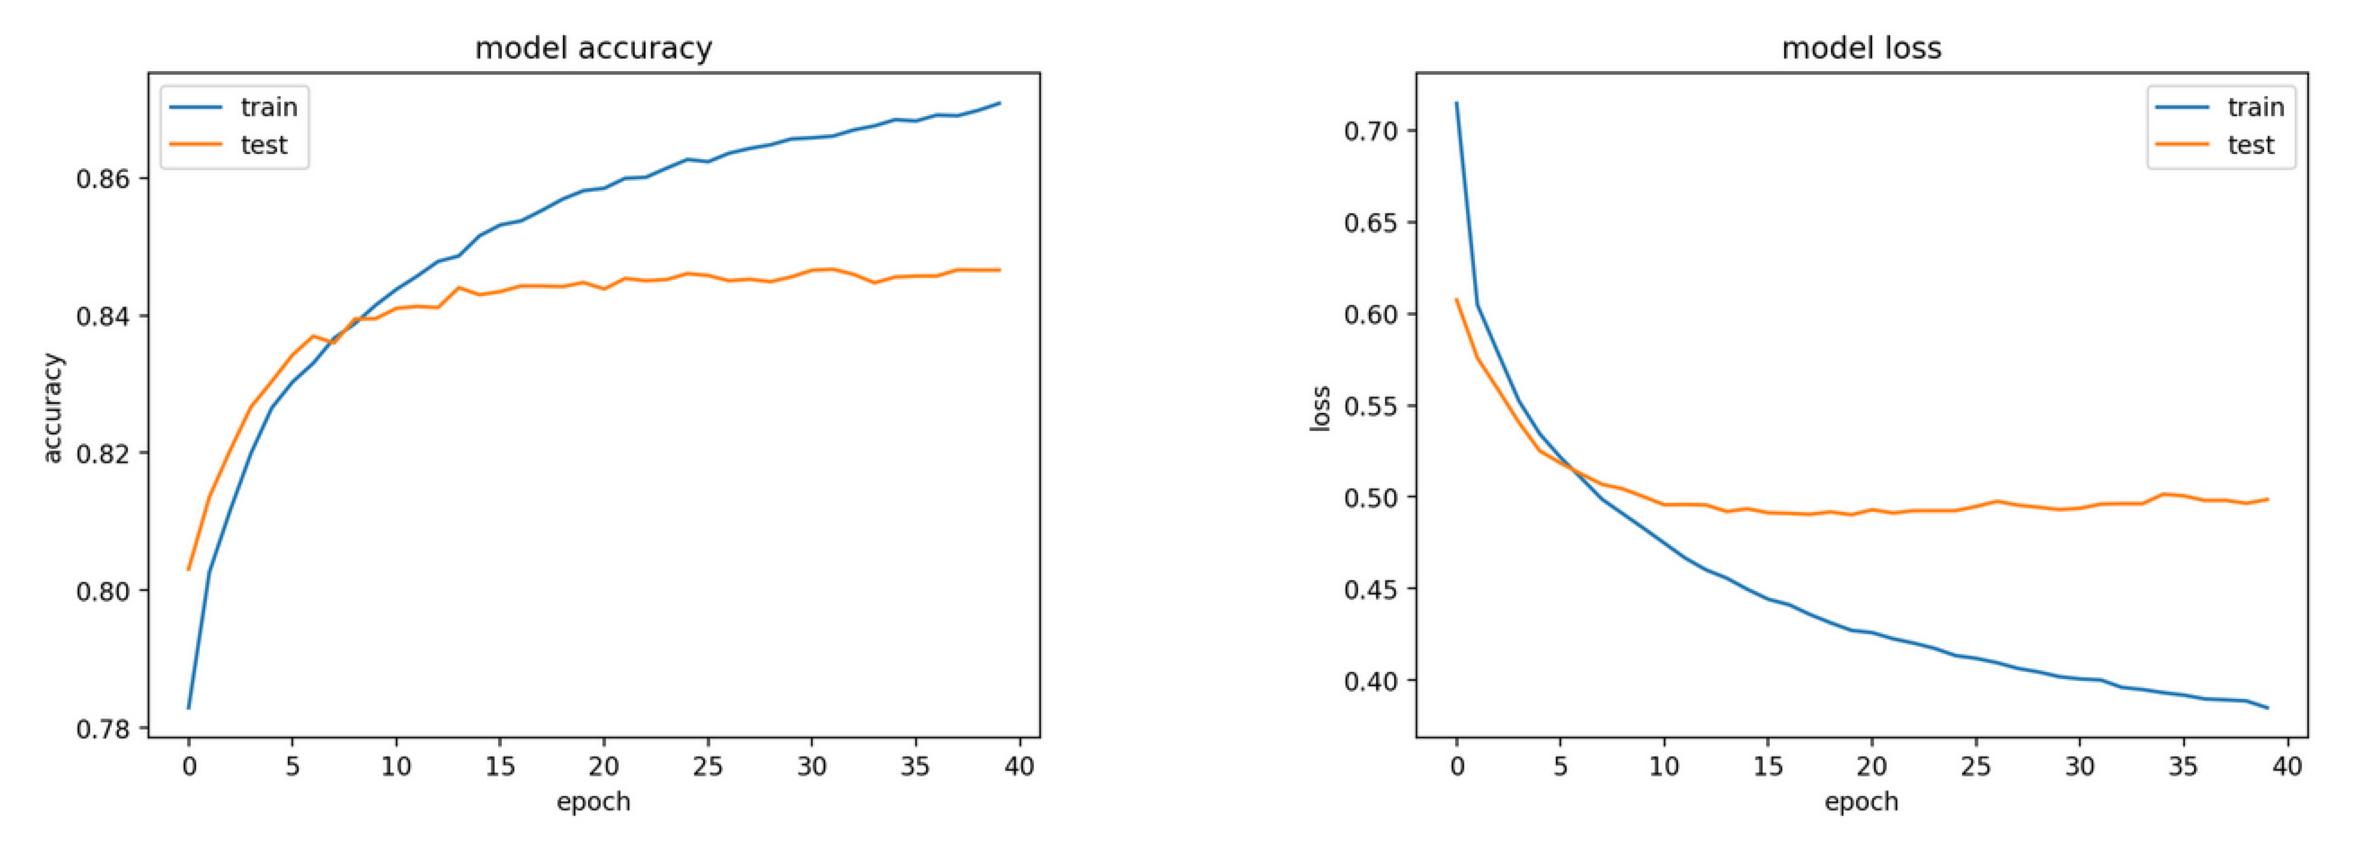

In [23]:
plt.figure(figsize = (15,15))
acc_curve = cv2.cvtColor(cv2.imread('acc_curve.png'), cv2.COLOR_BGR2RGB)
loss_curve = cv2.cvtColor(cv2.imread('loss_curve.png'), cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1), plt.imshow(acc_curve)
plt.axis('off')
plt.subplot(1,2,2), plt.imshow(loss_curve)
plt.axis('off')

In [24]:
model = keras.models.load_model('model.h5')

2024-09-25 20:38:52.219937: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 38)]        0         
                                                                 
 lstm (LSTM)                 (None, 256)               302080    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 38)                9766      
                                                                 
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________


<h1 style="color:blue; font-weight:bold;"> Melody Generation </h1>

The final step is to translate the model output into a language that can be used by the music21 library. To do this, we use the following functions:

- The *sample_with_temperature* function handles the main part of sampling, i.e. how to choose the next note according to the probabilities predicted by the model.  
For this, we use a parameter, the temperature, to adjust the unpredictability of the predictions: the higher the temperature, the more notes predicted with a low probability will be selected, increasing the creative aspect of the melody. On the other hand, with a lower temperature, the note predicted with the highest probability will be chosen: the prediction is more deterministic.

- Next, we use the *generate_melody* function to create a melody from a seed, using parameters to delimit the melody, the mapping and the model previously trained.

- Finally, we encode the generated melody in the midi format thanks to the function *save_melody*.

In [26]:
def sample_with_temperature(probabilities, temperature):
    predictions = np.log(probabilities) / temperature
    probabilities = np.exp(predictions) / np.sum(np.exp(predictions)) # Softmax function
    choices = range(len(probabilities))
    index = np.random.choice(choices, p = probabilities)
    return index 

def generate_melody(seed, mapping, model, temperature, start_symb = ['/']*64, num_steps = 500, max_seq_len = 64):
    seed = seed.split()
    melody = seed
    seed = start_symb + seed
    seed = [mapping[symbol] for symbol in seed]
    
    for k in range(num_steps):
        seed = seed[-max_seq_len:]
        onehot_seed = keras.utils.to_categorical(seed, num_classes=len(mapping))
        onehot_seed = onehot_seed[np.newaxis, ...]
        probabilities = model.predict(onehot_seed, verbose=0)[0]
        output_int = sample_with_temperature(probabilities, temperature)
        seed.append(output_int)
        output_symbol = [k for k, v in mapping.items() if v == output_int][0]
        if output_symbol == "/":
            break
            
        melody.append(output_symbol)

    return melody

In [27]:
def save_melody(melody, filename, step_duration=0.25, format="midi"):
    if not os.path.exists('./created_melodies/'):
        os.makedirs('./created_melodies/')
    stream = m21.stream.Stream()
    start_symbol = None
    step_counter = 1
    for i, symbol in enumerate(melody):
        if symbol != "_" or i + 1 == len(melody):
            if start_symbol is not None:
                duration = step_duration * step_counter 
                if start_symbol == "r":
                    symbol_to_encode = m21.note.Rest(quarterLength=duration)
                else:
                    symbol_to_encode = m21.note.Note(int(start_symbol), quarterLength=duration)
                stream.append(symbol_to_encode)
                step_counter = 1

            start_symbol = symbol
        else:
            step_counter += 1
    stream.write(format, filename)

In [28]:
def generate_and_save_melody(seed, mapping, model, temperature, filename):
    generated_mel = generate_melody(seed, mapping, model, temperature)
    save_melody(generated_mel, filename)

<h1 style="color:blue; font-weight:bold;"> Examples </h1>

To complete this project, we're trying to generate several melodies from two different seeds, using different temperatures.  
As expected, the higher the temperature, the more varied the notes, to reinforce the melody's creative aspect. 

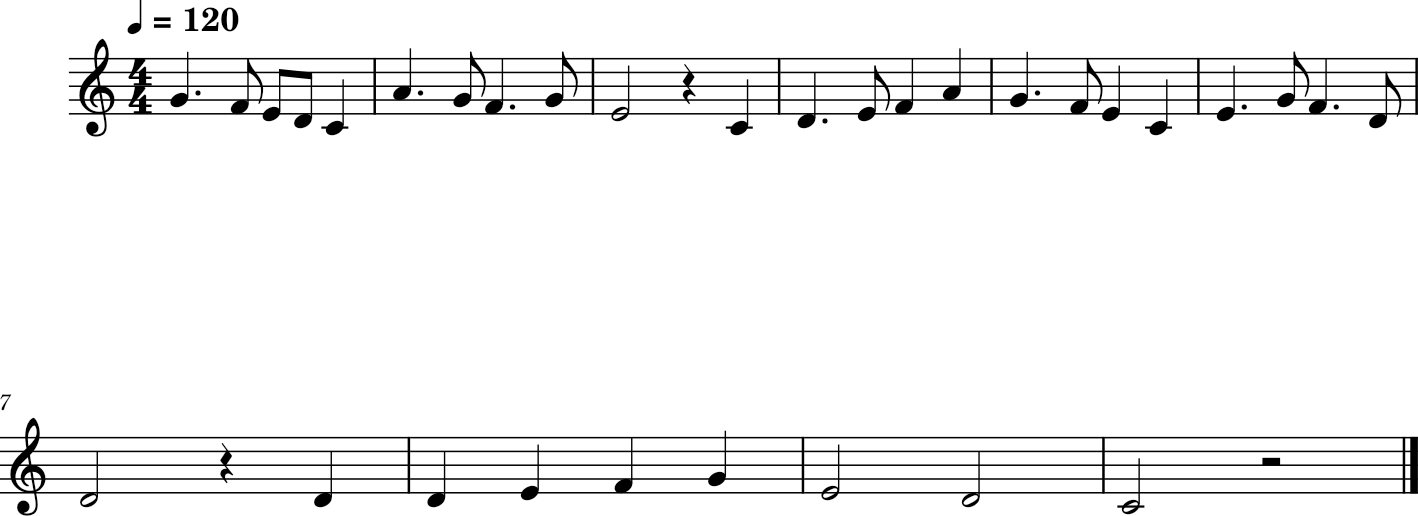

In [33]:
seed1 = '67 _ _ _ _ _ 65 _ 64 _ 62 _ 60 _ _ _'
generate_and_save_melody(seed1, mapping, model, 0.8, './created_melodies/seed1_08.mid')
generated_song = m21.converter.parse('./created_melodies/seed1_08.mid')
if MuseScore_installed:
    generated_song.show()

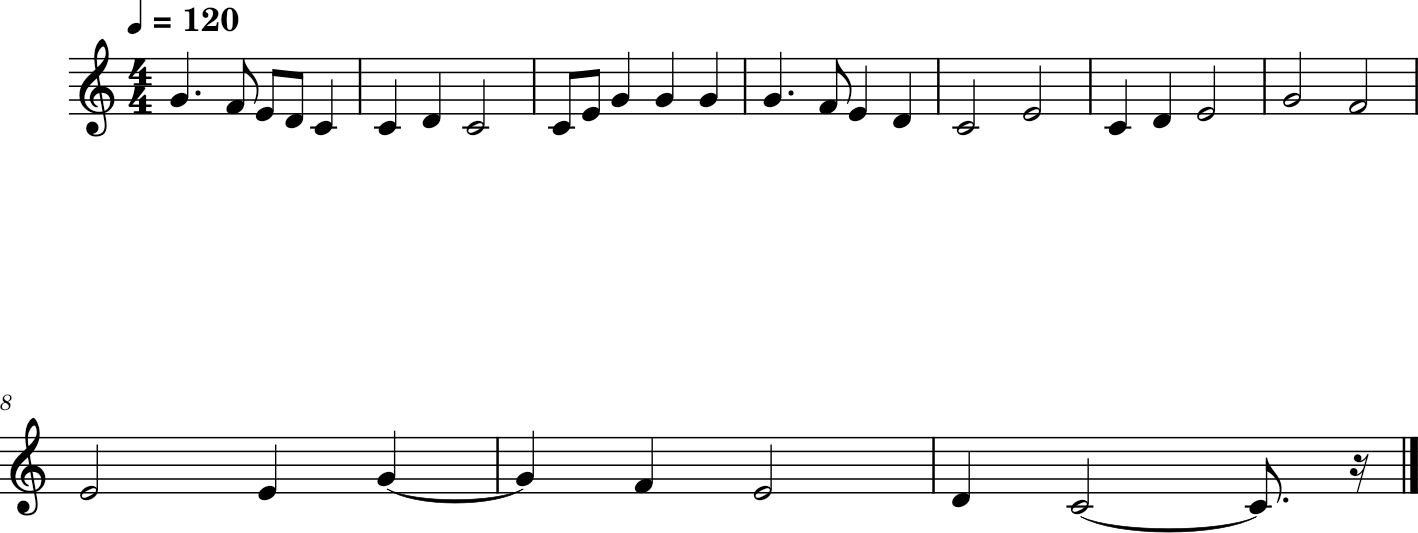

In [34]:
seed1 = '67 _ _ _ _ _ 65 _ 64 _ 62 _ 60 _ _ _'
generate_and_save_melody(seed1, mapping, model, 0.5, './created_melodies/seed1_05.mid')
generated_song = m21.converter.parse('./created_melodies/seed1_05.mid')
if MuseScore_installed:
    generated_song.show()

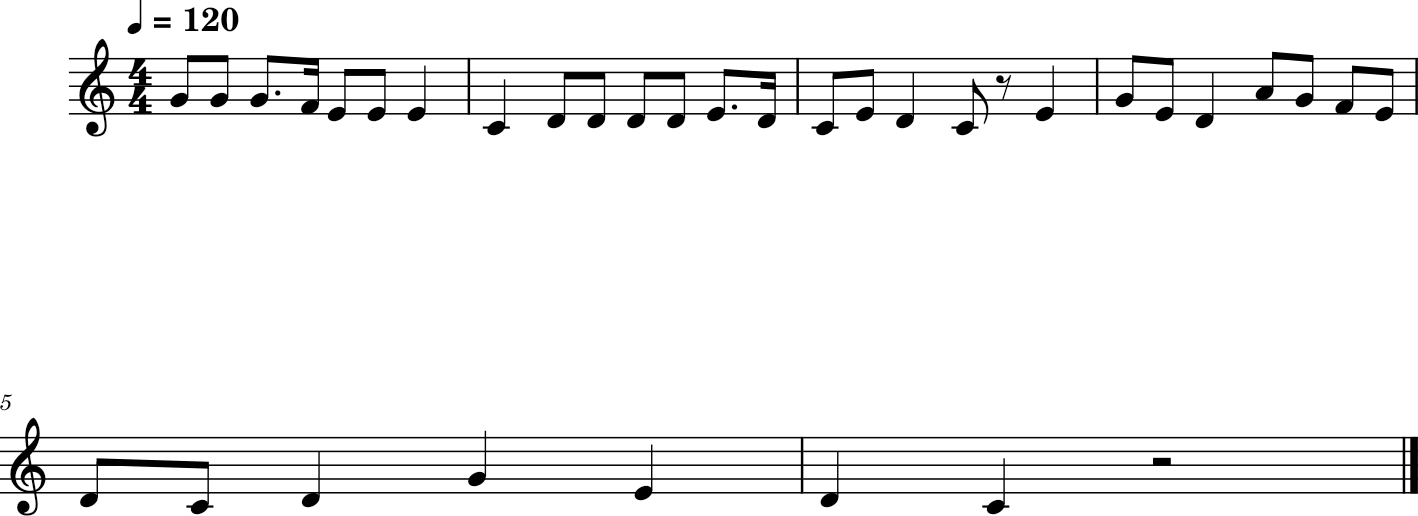

In [38]:
seed2 = '67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _'
generate_and_save_melody(seed2, mapping, model, 0.8, './created_melodies/seed2_08.mid')
generated_song = m21.converter.parse('./created_melodies/seed2_08.mid')
if MuseScore_installed:
    generated_song.show()

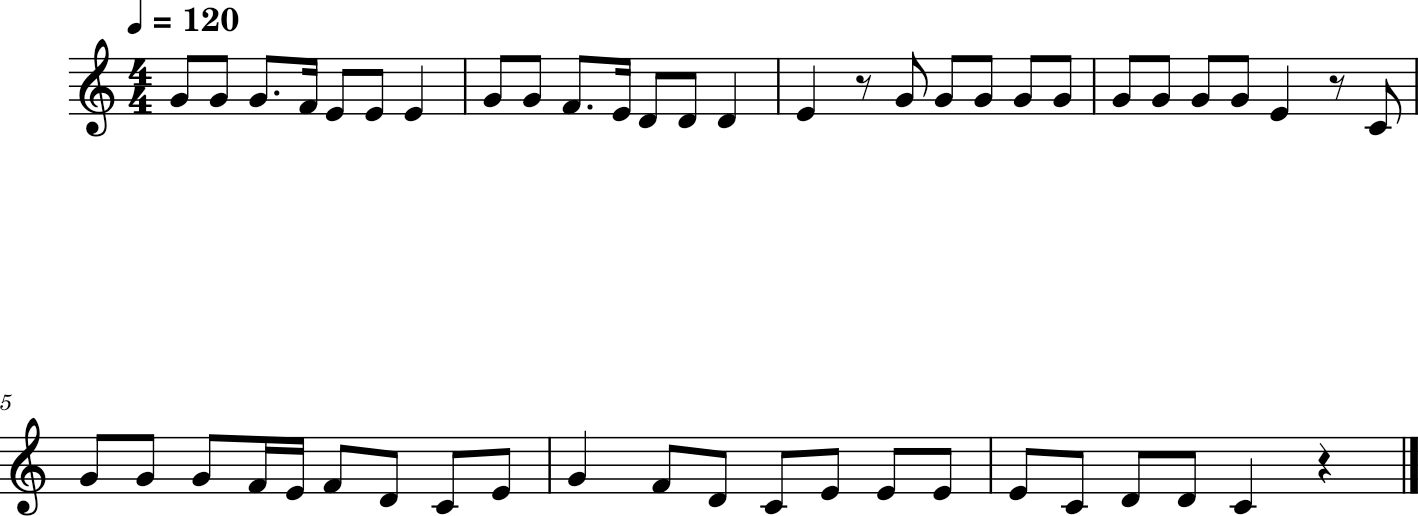

In [36]:
seed2 = '67 _ 67 _ 67 _ _ 65 64 _ 64 _ 64 _ _'
generate_and_save_melody(seed2, mapping, model, 0.5, './created_melodies/seed2_05.mid')
generated_song = m21.converter.parse('./created_melodies/seed2_05.mid')
if MuseScore_installed:
    generated_song.show()

One can try to listen the generated mid file without MuseScore thanks to online tools such as https://midi-player.en.softonic.com/ or https://signal.vercel.app/ . 